# Harmonising Landsat and sentinel

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="HLS")

### Analysis parameters


In [3]:
# Define the area of interest
#Northern Nigeria
# latitude = 12.24142
# longitude = 9.33816

#Southern Nigeia
# latitude = 8.05477
# longitude = 11.01148

# #Northern Ghana
# latitude = 10.15034
# longitude = 0.34555

#Southen Ghana
# latitude = 6.05653
# longitude = 0.50653

#western ivory coast
# latitude = 9.52254
# longitude = -5.57921

# Guinea Part
# latitude = 10.75481
# longitude = -11.05431

#Guinea Southern 
# latitude = 9.45168
# longitude = -13.46149

# Ethiopia
# latitude = 9.70906
# longitude = 38.62793

#kenya
latitude = -4.39023
longitude = 33.09082

buffer = 0.2


# Combine central lat,lon with buffer to get area of interest
lat_range = (latitude-buffer, latitude+buffer)
lon_range = (longitude-buffer, longitude+buffer)

# Set the range of dates for the complete sample
time = ('2019')



## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Landsat data

In [5]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time,
    'measurements': ['red','nir'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'min_gooddata':0.5
}

# find the right crs for the location
crs = 'EPSG:6933'

In [6]:
# load cloud-masked fractional cover using load_ard
ds = load_ard(dc=dc,
              **query,
              products=['ls8_sr'],
              align=(15, 15),
              output_crs=crs,
             )

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 28 out of 42 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 28 time steps


In [7]:
# load cloud-masked fractional cover using load_ard
ds_sentinel = load_ard(dc=dc,
              **query,
              products=['s2_l2a'],
              align=(15, 15),
              output_crs=crs,
        
             )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 240 out of 290 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 240 time steps


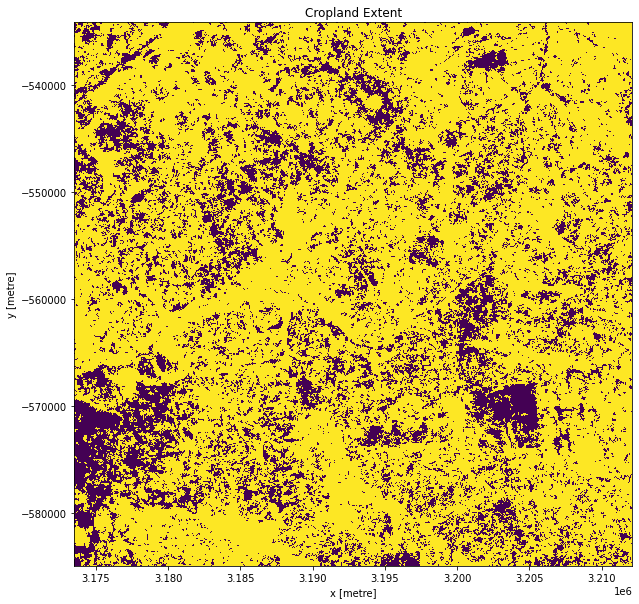

In [9]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(10,10))
plt.title('Cropland Extent');

In [10]:
ds_mask = ds.where(cm, np.nan)

In [11]:
ds_sen_mask = ds_sentinel.where(cm, np.nan)

In [12]:
ndvi_landsat = calculate_indices(ds_mask, 'NDVI', collection='c2', drop=True)
ndvi_sentinel = calculate_indices(ds_sen_mask, 'NDVI', collection='s2', drop=True)

Dropping bands ['red', 'nir']
Dropping bands ['red', 'nir']


In [13]:
landsat_plot = ndvi_landsat.mean(dim=['x','y']).NDVI

In [14]:
sentinel_plot = ndvi_sentinel.mean(dim=['x','y']).NDVI

#### Harmonising Landsat 8 and Sentinel 2 Dataset

https://www.sciencedirect.com/science/article/pii/S0034425718305212?via%3Dihub

In [15]:
#multiplying the red band with slope and adding to intercept
slope = 0.982
intercept = 0.00094
ds_red_con  = (ds_mask.red * slope) + intercept

In [16]:
#multiplying the nir band with slope and adding to intercept
slope = 0.8954
intercept = 0.0033
ds_nir_con  = (ds_mask.nir * slope) + intercept

#### Calculating NDVI for the converted Landsat

In [17]:
#calculating NDVI using converted red and nir band  
ndvi_hl = (ds_nir_con  -  ds_red_con ) / (ds_nir_con + ds_red_con)

In [18]:
ndvi_hl_plot = ndvi_hl.mean(dim=['x','y'])

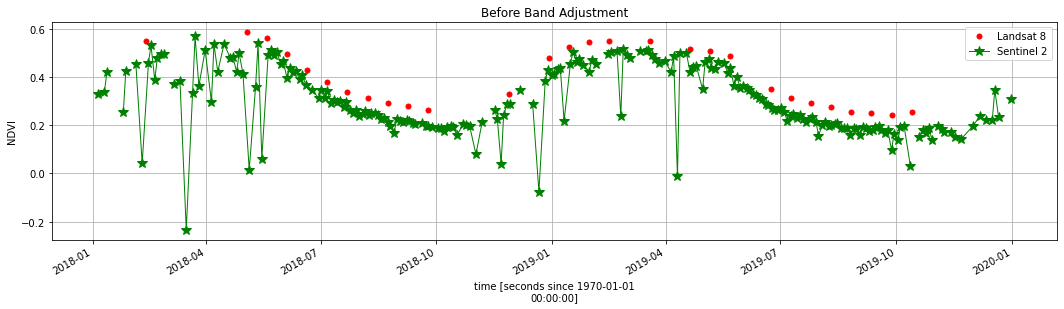

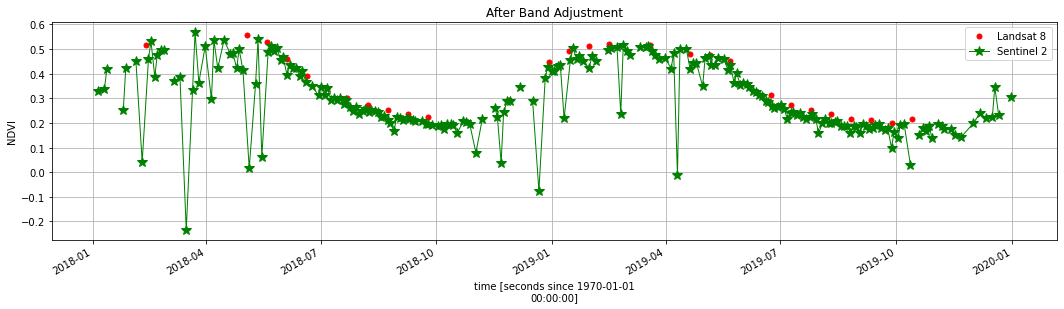

In [19]:
plt.figure(figsize=(18, 4))
landsat_plot.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
sentinel_plot.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('Before Band Adjustment')
plt.grid()

plt.figure(figsize=(18, 4))
ndvi_hl_plot.plot(marker='.', lw=0, color='red', ms=10, label='Landsat 8')
sentinel_plot.plot(marker='*', lw=1, ms=10, color='green', label='Sentinel 2')
plt.legend()
plt.title('After Band Adjustment')

plt.grid()
plt.show()